In [2]:
import requests
from json import dumps

endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
area_type = "nation"
area_name = "england"

filters = [f"areaType={area_type}", f"areaName={area_name}"] 

structure = {
    "date": "date",
    "name": "areaName",
    "code": "areaCode",
    "dailyCases": "newCasesByPublishDate",
    "cumulativeCases": "cumCasesByPublishDate",
    "dailyDeaths": "newDeaths28DaysByPublishDate",
    "cumulativeDeaths": "cumDeaths28DaysByPublishDate"}

api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))}

response = requests.get(endpoint, params=api_params, timeout=10)
if response.status_code >= 400: # catch error if no response recieved
    raise RuntimeError(f"Request failed: {response.text}")

In [3]:
import pandas as pd 

data = response.json()["data"]
df = pd.DataFrame(data)

Make a graph from the cumulative cases over covid-19 over time from the pandas dataframe

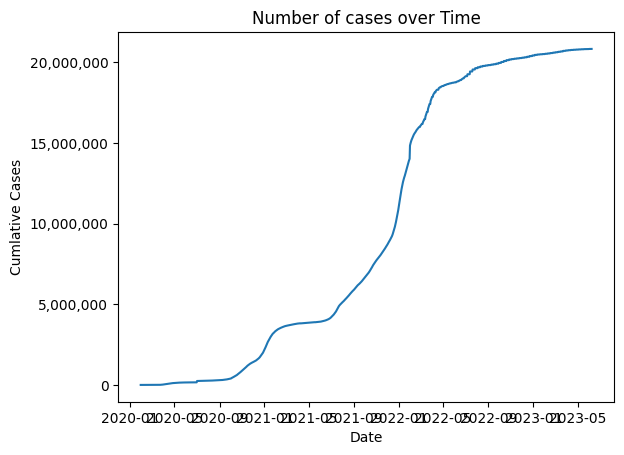

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick


df['date'] = pd.to_datetime(df['date'])

# line graph of cumlativeCases using seaborn
sns.lineplot(x='date', y='cumulativeCases', data=df)

# x/y labels and title
plt.xlabel('Date')
plt.ylabel('Cumlative Cases')
plt.title('Number of cases over Time')

# format to display y axis as 1,000,000 vs scientific notation e.g 
formatter = tick.FuncFormatter(lambda y, _: '{:,.0f}'.format(y))

# apply above to y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# show graph
plt.show()

Perform seasonal decomposition analysis on the data 

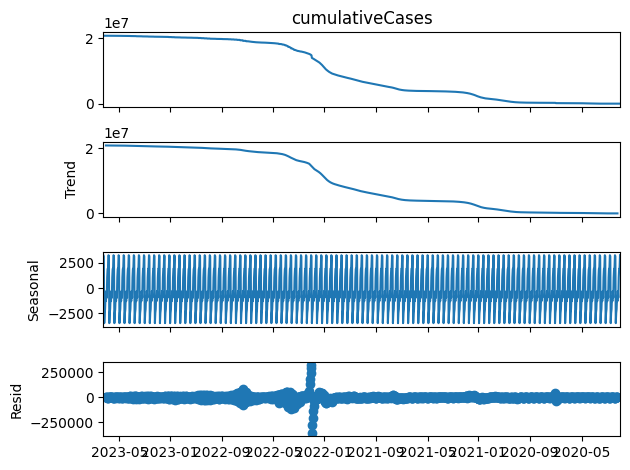

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

# convert to datetime
df['date'] = pd.to_datetime(df['date'])

# set index
df.set_index('date', inplace=True)

# perfrom statistical analysis 
result = seasonal_decompose(df['cumulativeCases'], model='additive', period=12)

# plot data in a graph
result.plot()

#show graph
plt.show()